# 傾向スコアを用いた TV CM の視聴によるゲーム利用傾向の変化の分析

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

from pycalf import metrics
from pycalf import propensity_score

まずはじめに、サンプルデータを取得する。

In [3]:
# Download from https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv
df = pd.read_csv('sample/q_data_x.csv')

In [4]:
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


傾向スコアを求めるために、共変量・結果変数・介入変数を定義します。

In [5]:
# Define variables required for inference.
covariate_cols = [
    'TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney',
    'area_kanto', 'area_tokai', 'area_keihanshin', 'job_dummy1', 'job_dummy2',
    'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7',
    'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'
]
outcome_cols = ['gamecount', 'gamedummy', 'gamesecond']
treatment_col = 'cm_dummy'

傾向スコアを求めるモデルにはロジスティック回帰を用いるので、共変量をスケーリングします。

そして、IPWを用いたモデルを定義します。

In [6]:
# Set Values from dataframe.
X = df[covariate_cols]
y = df[outcome_cols]
treatment = df[treatment_col].astype(bool).to_numpy()

# Scaling Raw Data.
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Define IPW Class.
learner = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
model = propensity_score.IPW(learner)

# Fit model.
model.fit(scaled_X, treatment)

### 効果量dを用いた共変量の調整の様子を確認

IPW によって、共変量のばらつきが調整されたのかを効果量dを用いて確認する。

In [7]:
ate_weight = model.get_weight(treatment, mode='ate')
es = metrics.EffectSize()
es.fit(X, treatment, weight=ate_weight)
es.transform()

(array(['TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc',
        'pmoney', 'area_kanto', 'area_tokai', 'area_keihanshin',
        'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4',
        'job_dummy5', 'job_dummy6', 'job_dummy7', 'fam_str_dummy1',
        'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'], dtype=object),
 array([0.13846538, 0.07087411, 0.04615925, 0.02934219, 0.0119451 ,
        0.07186398, 0.00322885, 0.02722615, 0.14518075, 0.01426944,
        0.08135214, 0.03176526, 0.00282704, 0.01120574, 0.05837685,
        0.00744712, 0.0505439 , 0.06158705, 0.01347874, 0.06350157,
        0.00177609]))

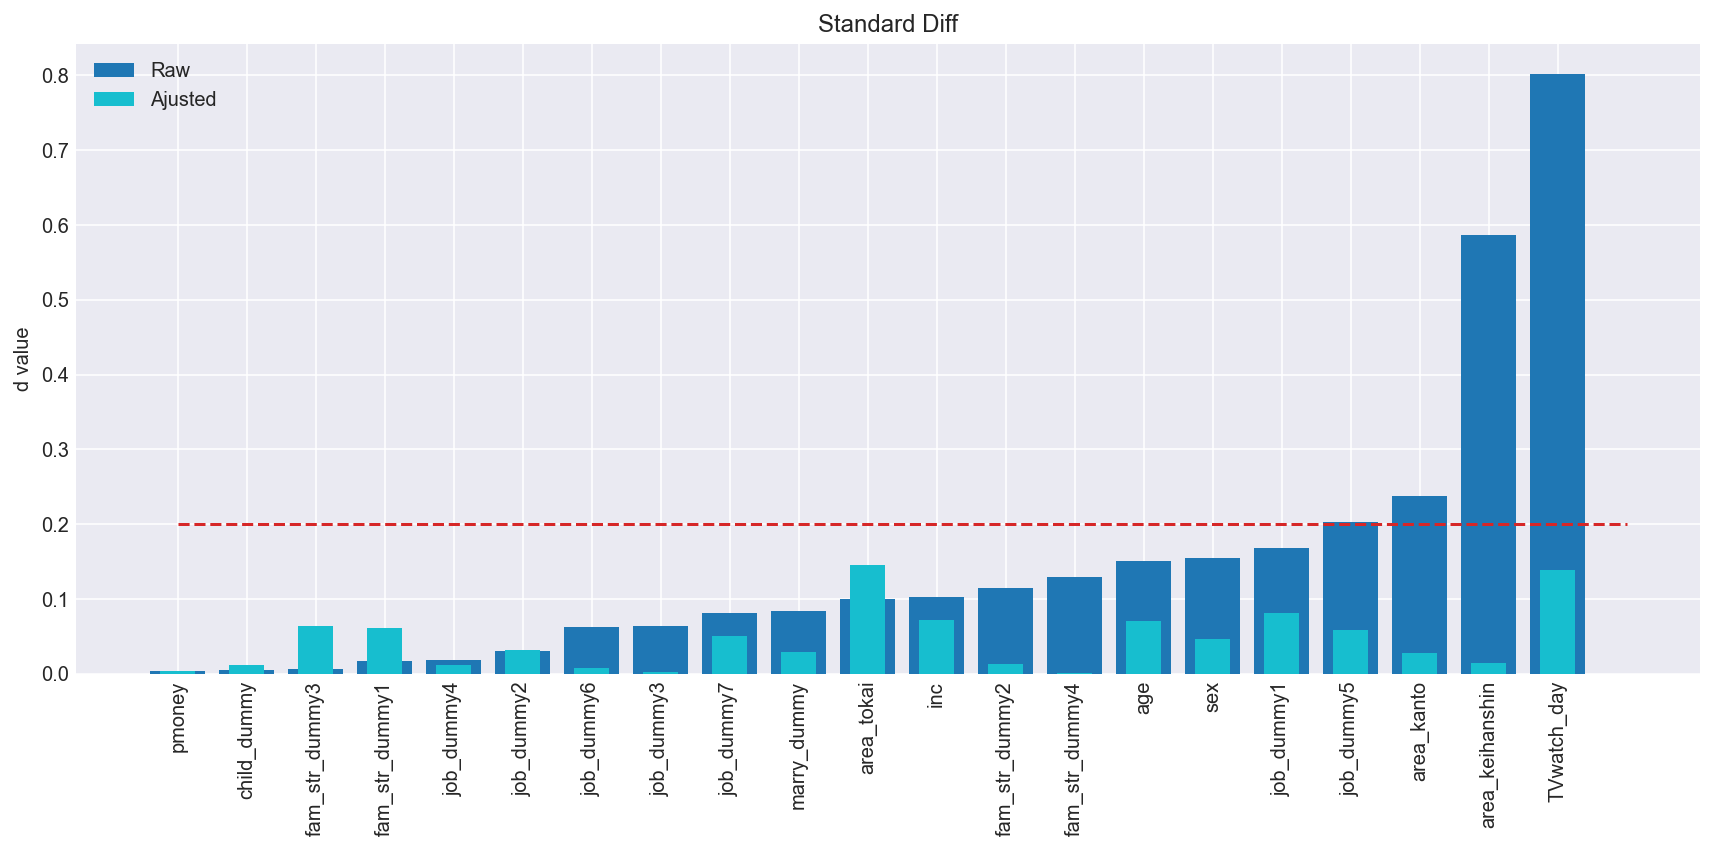

In [8]:
metrics.plot_effect_size(X, treatment, weight=ate_weight, ascending=True)

### AUC と 傾向スコアの分布の可視化

ここでは、AUC と 介入有無別の傾向スコアの分布を可視化する。

AUC は、0.7 以上であることが好ましいとされる。
参考：https://www.jstage.jst.go.jp/article/tenrikiyo/19/2/19_19-008/_pdf

介入有無別の傾向スコアの分布は、ある程度重なりが有りながら介入有無別の分布が別れているので傾向スコアによる調整が行えるように見える。

F1 Score:  0.6839307927174036


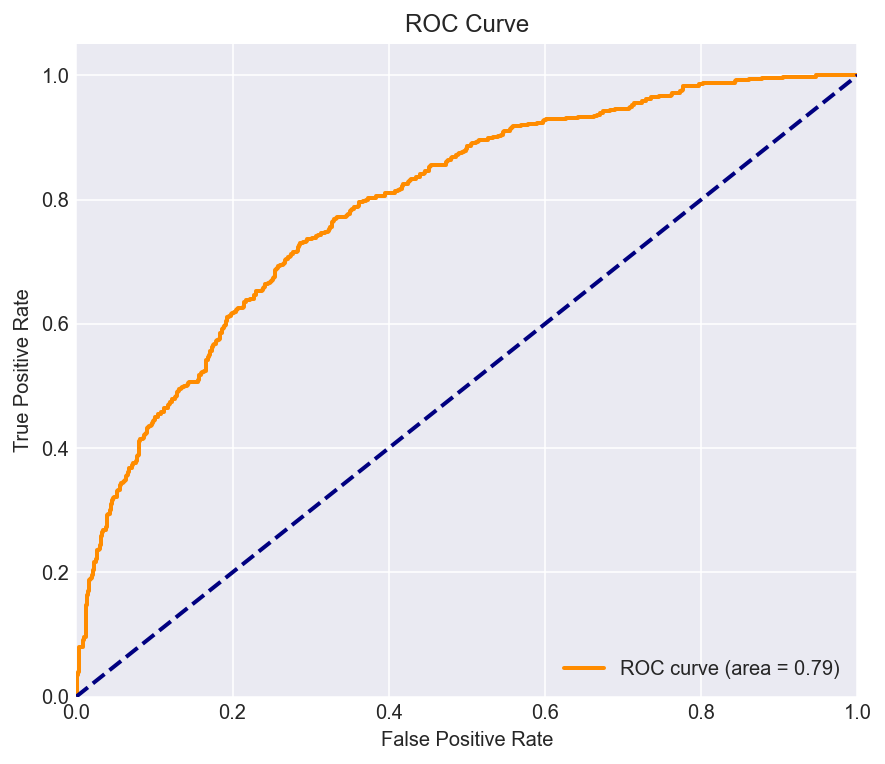

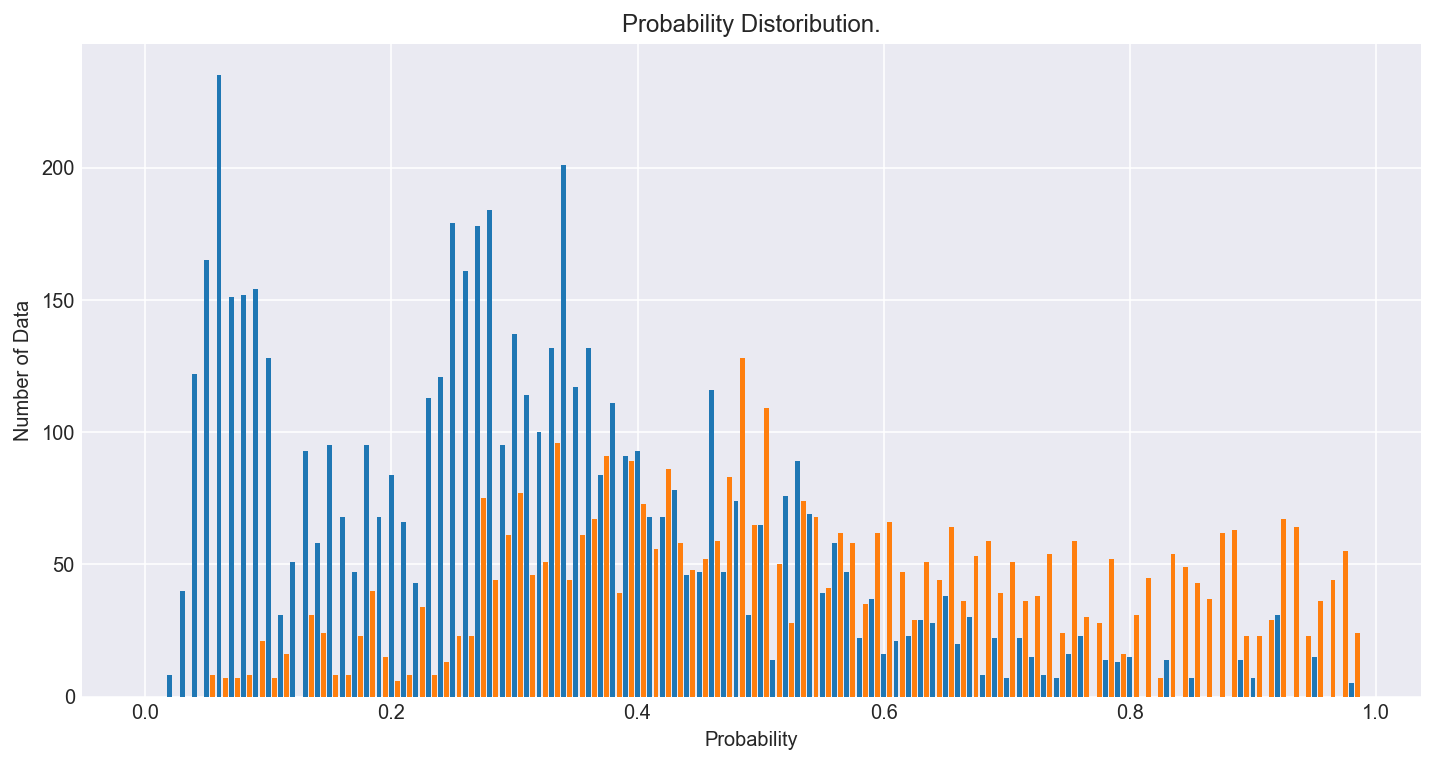

In [9]:
print('F1 Score: ', metrics.f1_score(treatment, model.get_score(), threshold='auto'))
metrics.plot_roc_curve(treatment, model.get_score())
metrics.plot_probability_distribution(treatment, model.get_score())

### 平均処置効果（ATE: Average Treated Effect）

IPW による調整後の介入効果

In [10]:
outcome = model.estimate_effect(treatment, y.to_numpy(), mode='ate')
pd.DataFrame(outcome, index=['Z0', 'Z1', 'ATE'], columns=y.columns.tolist()).T

,Z0,Z1,ATE
gamecount,8.488374,13.121695,4.633321
gamedummy,0.063544,0.093011,0.029466
gamesecond,2691.407119,3959.155313,1267.748194


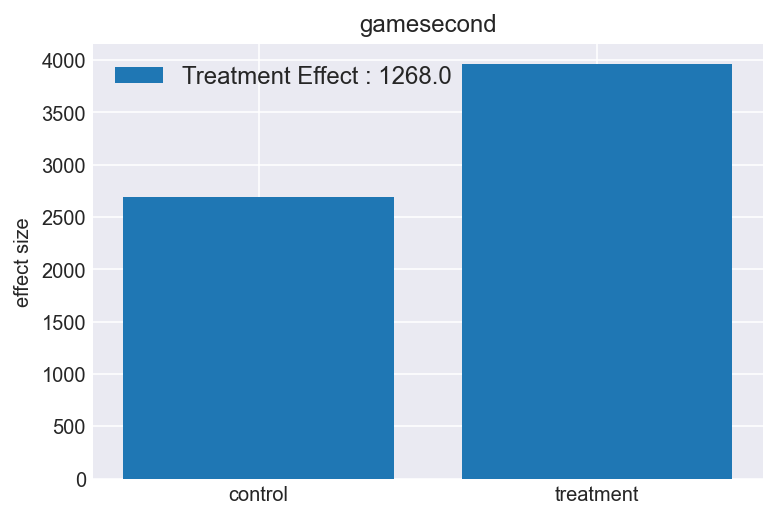

In [11]:
outcome_name = 'gamesecond'
z0, z1, treat_effect = model.estimate_effect(treatment, y[outcome_name].to_numpy(), mode='ate')
metrics.plot_treatment_effect(outcome_name, z0, z1, treat_effect.round())

### 属性変数を用いた介入効果の推定

,Z0_effect,Z0_tvalue,Z1_effect,Z1_tvalue,Lift
T,5814.6,2.77**,-530.3,-0.23,-6344.9
M1,5816.2,9.12**,251.6,0.24,-5564.6
area_tokai,2120.6,3.62**,-1349.9,-1.34,-3470.5
area_kanto,1967.6,2.59**,188.6,0.38,-1779.0
child_dummy,1801.7,3.5**,1051.6,2.15**,-750.1
F1,-974.5,-1.51,-1637.4,-2.45**,-662.9
area_keihan,1998.2,5.22**,2011.0,4.79**,12.8
area_keihanshin,889.5,1.65,1240.7,1.04,351.2
M3,-1345.2,-2.36**,-797.1,-1.47,548.1
M2,-343.1,-0.74,341.5,0.72,684.6


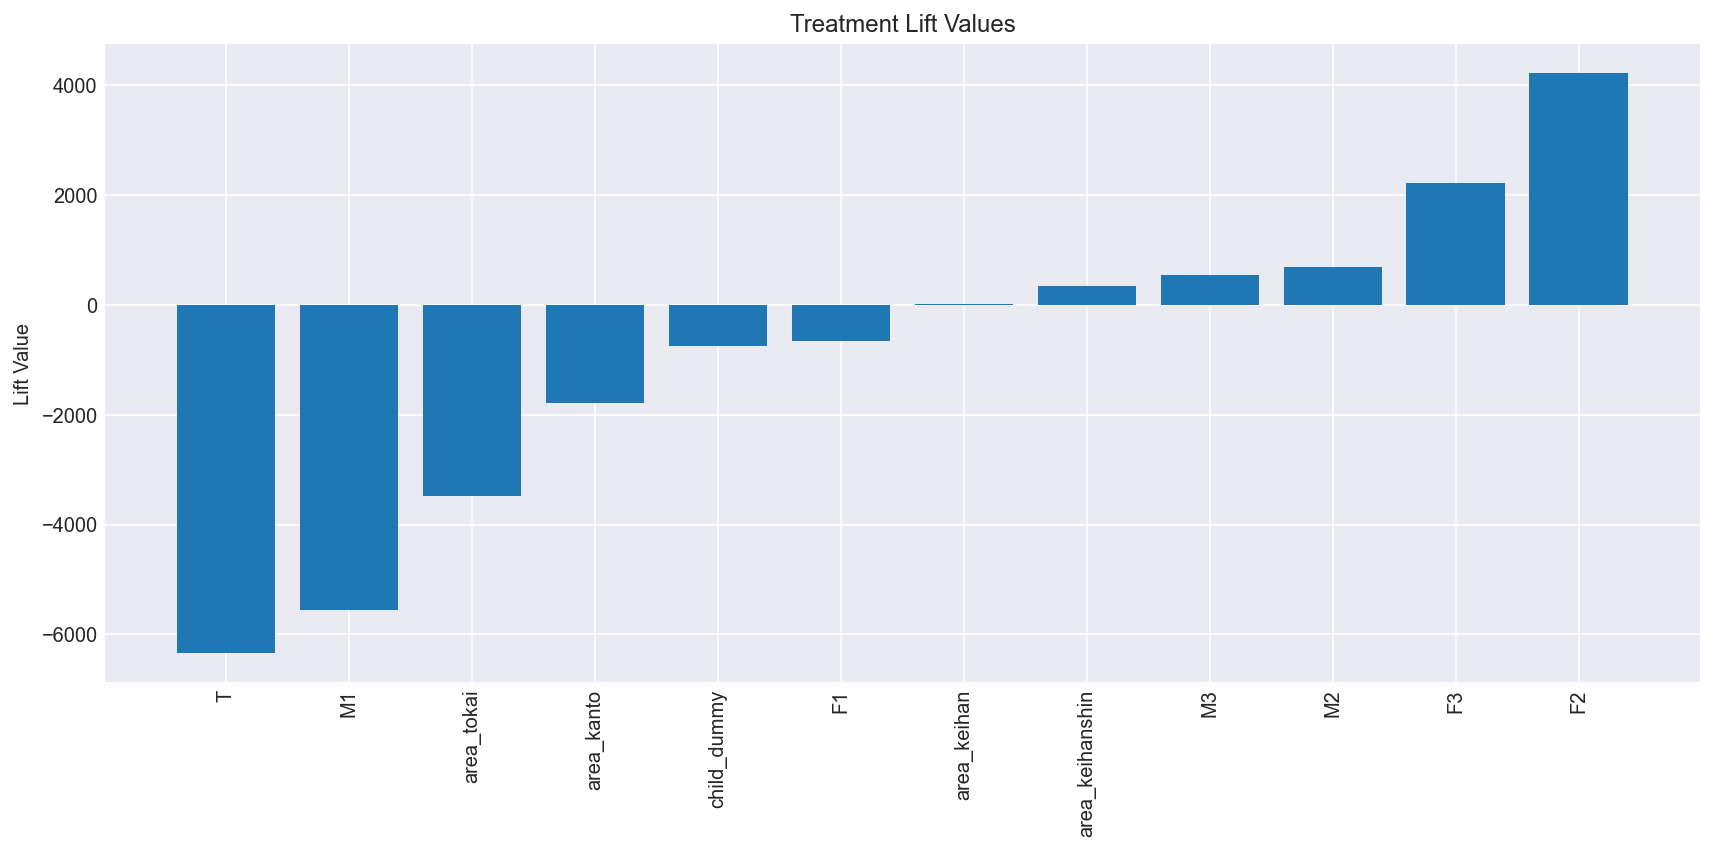

In [12]:
# Attribute Effect
treatment_col = 'cm_dummy'
y = 'gamesecond'
features = [
    'child_dummy', 'area_kanto', 'area_keihan', 'area_tokai', 'area_keihanshin',
    'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3'
]

attr_effect = metrics.AttributeEffect()
attr_effect.fit(df[features], df[treatment_col], df[y], weight=model.get_weight('ate'))
result = attr_effect.transform()

display(result)
attr_effect.plot_lift_values()